# API design ideas for maxentropy

It is well known that the normal / Gaussian distribution is the distribution with maximum entropy subject to constraints on the first two moments. In this example we show the shapes of some distributions that arise when we place a bounds constraint in addition to constraints on the first two moments.

In [1]:
from scipy import stats
import scipy.sparse
import numpy as np
import pandas as pd

import maxentropy

In [2]:
def f0(x):
    return x

In [3]:
def f1(x):
    return x**2

In [4]:
def f2(x):
    return (lower < x) & (x < upper)

In [5]:
features = [f0, f1, f2]

### Example 1

Fit the maximum entropy model subject to the constraints $E(X)=0, E(X^2)=1, P(-2.5<X<2.5)=1$

In [6]:
# Bounds and target expectations
lower, upper = (-2.5, 2.5)
target_expectations = [0, 1, 1]      # E(X) = 0, E(X^2)=1, P(lower<x<upper)=1

We will be doing importance sampling along the support of the model we fit, so we need to define an auxiliary distribution for sampling that is at least as wide and flat as the model we're trying to fit.

After fitting, our model will be bounded $(-2.5, 2.5)$ so we need an auxiliary distribution that covers this domain well. We'll choose a uniform continuous distribution $U[-3, 3]$ here. (Going a little bit wider is helpful for the plot, to see the truncation outside the interval $[-2.5, 2.5]$.

To do this we use scipy.stats:

According to the docs for `scipy.stats.uniform`:

> In the standard form, the distribution is uniform on ``[0, 1]``. Using
the parameters ``loc`` and ``scale``, one obtains the uniform distribution
on ``[loc, loc + scale]``.

Since `[lower, upper] = [loc, loc + scale]`, we have:

In [7]:
loc, scale = -3.0, 6.0

In [8]:
mu = target_expectations[0]
sigma = (target_expectations[1] - mu**2)**0.5
mu, sigma

(0, 1.0)

We create `sampler` as a generator function that will be used for importance sampling. This yields a tuple `(sample_xs, log_q_xs)` whose dimensions are `(n, d)` and `(n,)`.

In [9]:
from maxentropy.utils import auxiliary_sampler_scipy

In [10]:
sampler = auxiliary_sampler_scipy(stats.uniform(loc=loc, scale=scale), n_dims=1, n_samples=10**5)

In [11]:
sample_xs, log_q_xs = next(sampler)

In [12]:
sample_xs.shape, log_q_xs.shape

((100000, 1), (100000,))

In [13]:
# !pip install matplotlib

# import matplotlib.pyplot as plt
# plt.hist(sample_xs, density=True);

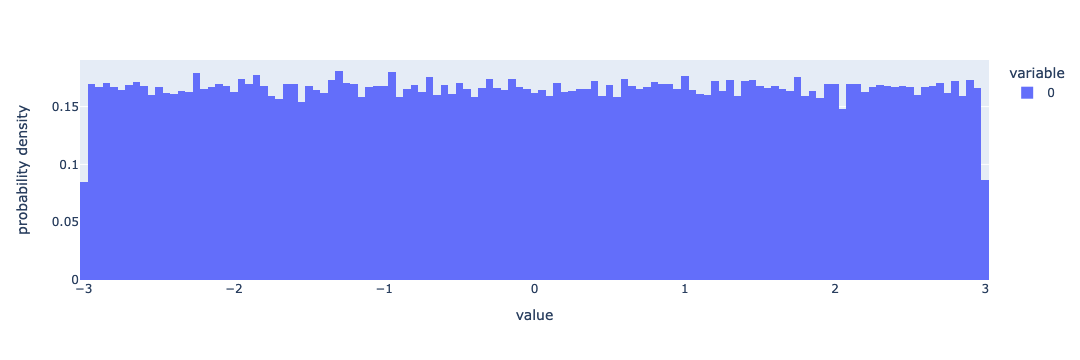

In [14]:
import plotly.express as px

px.histogram(sample_xs[:, 0], histnorm='probability density')

We pass `features` as a single vectorized function that returns a matrix or list of (preferably) vectorized functions that each operate on each vector of samples xs = `[x_1,...,x_n]`.

In [15]:
features

[<function __main__.f0(x)>,
 <function __main__.f1(x)>,
 <function __main__.f2(x)>]

In [16]:
# Create a model
model = maxentropy.MCMinDivergenceModel(features, sampler, array_format='csc_matrix', verbose=False)

In [17]:
# This should be internal within maxentropy:
# def sampleFgen(sampler, f, sparse_format="csc_matrix"):
#     """
#     A generator function that yields features of random points.

#     Parameters
#     ----------
#         sampler: a generator that yields tuples (xs, logprobs)

#         f: a list of feature functions to apply to the values x in xs

#         sparse_format: either 'csc_matrix', 'csr_matrix' etc.
#                        for constructing a scipy.sparse matrix of features

#     Yields
#     ------
#         a tuple (F, logprobs), where:
#             - F is a sparse feature matrix
#             - logprobs is the same vector of log probs yielded by sampler
#     """
#     while True:
#         xs, logprobs = next(sampler)
#         F = utils.sparsefeaturematrix(f, xs, sparse_format)
#         yield F, logprobs


# print("Generating an initial sample ...")
# model.setsampleFgen(sampleFgen(sampler, features))

In [18]:
# Should be internal:
# X = np.reshape(target_expectations, (1, -1))
# X.shape

In [19]:
target_expectations

[0, 1, 1]

In [20]:
model.feature_expectations()  # before fitting

array([7.15782710e-04, 2.99622452e+00, 8.33780000e-01])

In [21]:
model.features                # should be a vectorized function based on the list of functions passed in, which returns a sparse matrix

<function maxentropy.base.BaseModel.__init__.<locals>.<lambda>(xs)>

In [22]:
sample_xs.shape

(100000, 1)

In [23]:
model.features(sample_xs).shape

(100000, 3)

In [24]:
model.features(sample_xs)[:5, :].A

array([[-1.58758327,  2.52042063,  1.        ],
       [ 2.00862834,  4.0345878 ,  1.        ],
       [-0.21707763,  0.0471227 ,  1.        ],
       [ 0.08210455,  0.00674116,  1.        ],
       [ 1.55441475,  2.4162052 ,  1.        ]])

In [25]:
[f(sample_xs[0]) for f in model.feature_functions]

[array([-1.58758327]), array([2.52042063]), array([ True])]

In [26]:
# model.sampleF[:, :5].A

In [27]:
# X

In [28]:
# X.shape

In [29]:
# model.fit(X)  # could be a dataset
model.fit(target_expectations)

MCMinDivergenceModel(auxiliary_sampler=<generator object auxiliary_sampler_scipy at 0x17c3bb040>,
                     feature_functions=[<function f0 at 0x17c45de40>,
                                        <function f1 at 0x17c45dee0>,
                                        <function f2 at 0x17c45e2a0>],
                     verbose=False)

In [30]:
model.feature_expectations()

array([1.63642514e-08, 9.99999998e-01, 9.99999996e-01])

In [31]:
np.abs(target_expectations - model.feature_expectations())

array([1.63642514e-08, 1.90300620e-09, 3.57196495e-09])

In [32]:
np.allclose(model.feature_expectations(), target_expectations, atol=1e-7)

True

In [33]:
# model.iters, model.fnevals

In [34]:
# TODO: perhaps change to .num_iters and .num_fn_evals, or whatever sklearn uses:
# model.num_iters, model.num_fn_evals

In [35]:
model.params

array([ 4.72615265e-03, -4.39914378e-01,  1.52092398e+01])

In [36]:
# TODO: add an underscore suffix for fitted parameters

In [37]:
# model.params_                         # add an underscore

In [38]:
# What should this do? Do we need it? Should it be a constant based on model.params_ rather than a method?
# Old: model.dual()
# New: perhaps model.entropy_dual_

In [39]:
model.dual()

1.403816905189485

After running this code, the `model` has a vector
of parameters $\theta = (\theta_i)^{3}_{i=1}$
stored as the array `model.params_`. The pdf of the fitted model can then be retrieved
with the `model.pdf` method and plotted as follows:



In [40]:
%matplotlib inline

In [41]:
lower, upper

(-2.5, 2.5)

In [42]:
# Plot the pdf:
xs = np.reshape(np.linspace(lower, upper, num=1000), (-1, 1))

In [43]:
xs.shape

(1000, 1)

In [44]:
model.features(xs)
# [f(x) for f in features]

<1000x3 sparse matrix of type '<class 'numpy.float64'>'
	with 2998 stored elements in Compressed Sparse Column format>

In [45]:
# Current API:
model.log_pdf_from_features(model.features(xs))[:5]

array([-18.93442257,  -3.71416127,  -3.7031618 ,  -3.69218438,
        -3.681229  ])

In [46]:
# Desired API:

In [47]:
y = model.predict_proba(xs)   # should we accept a 1d array x? Or should we demand a 2d matrix like scikit-learn does?
                              # Either way, internally, it should do this: (np.array([f(x) for f in features])) or the
                              # vectorized equivalent.

(0.0, 0.4195461862012092)

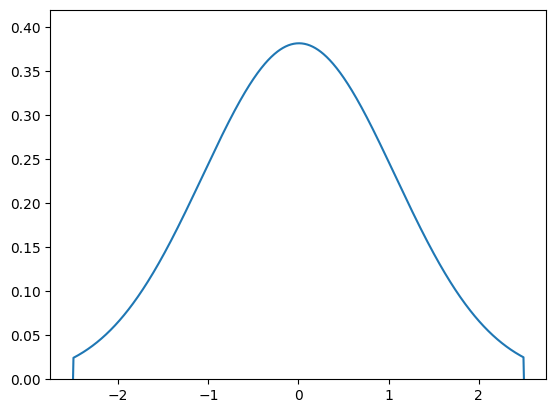

In [48]:
import matplotlib.pyplot as plt

plt.plot(xs, y)
plt.ylim(0, y.max()*1.1)

## Example 2: improving on a model / estimator by adding additional constraints (KL div minimization)

Here we take an example of constraining the probabilities in given regions with real data: statistics of the Forbes 2000 companies. We create an initial model for market value that cannot be negative.

In [49]:
import pandas as pd
forbes = pd.read_csv('https://github.com/PythonCharmers/PythonCharmersData/raw/master/forbes.csv')

In [50]:
forbes[:5]

rank                 name         country   sales  profits   assets  \
0     1            Citigroup   United States   94.71    17.85  1264.03   
1     2     General Electric   United States  134.19    15.59   626.93   
2     3  American Intl Group   United States   76.66     6.46   647.66   
3     4           ExxonMobil   United States  222.88    20.96   166.99   
4     5                   BP  United Kingdom  232.57    10.27   177.57   

   marketvalue  
0       255.30  
1       328.54  
2       194.87  
3       277.02  
4       173.54

In [51]:
mv = forbes['marketvalue'].dropna()

<Axes: >

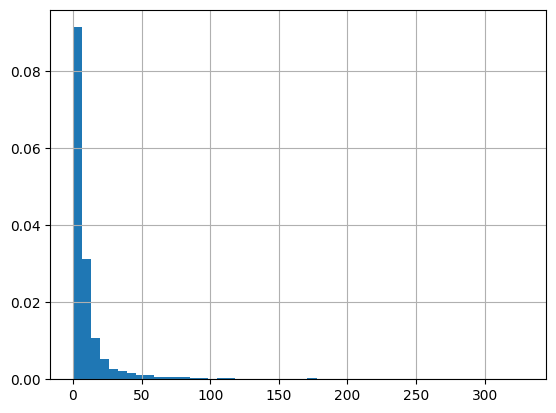

In [52]:
mv.hist(bins=50, density=True)

In [53]:
mv.describe()

count    1966.000000
mean       11.735549
std        24.302136
min         0.020000
25%         2.710000
50%         5.140000
75%        10.412500
max       328.540000
Name: marketvalue, dtype: float64

### Initial / prior model

Let's fit a simple (and poor) 1-dimensional Gaussian distribution model for "marketvalue" using scipy:

In [54]:
params = stats.norm.fit(mv)

In [55]:
params

(11.735549338758902, 24.29595431364111)

In [56]:
auxmodel = stats.norm(*params)

In [57]:
x = np.linspace(mv.min(), mv.max(), num=100)

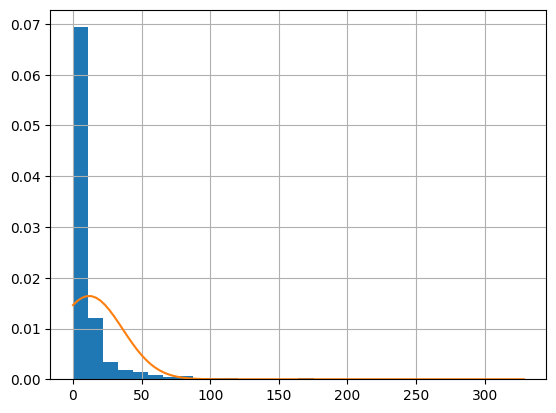

In [58]:
mv.hist(bins=30, density=True)
plt.plot(x, auxmodel.pdf(x))

(-1.0, 100.0)

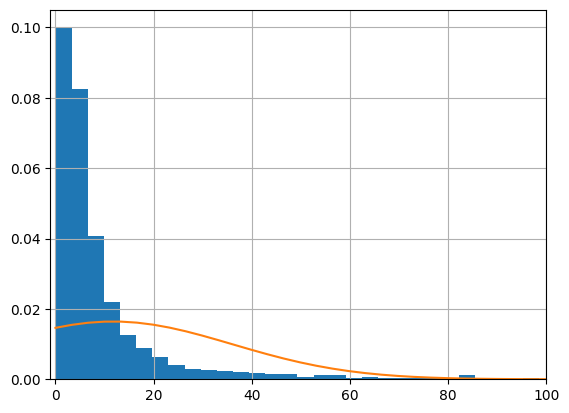

In [59]:
mv.hist(bins=100, density=True)
plt.plot(x, auxmodel.pdf(x))
plt.xlim(-1, 100)

In [60]:
auxmodel.cdf(0)

0.3145390510356489

#### Alternative formulation using `maxentropy`

In [61]:
# from  ... TODO

### Improving upon a given model

Clearly a failure of the model above is that it gives a large weight to values < 0.

What would be the density with closest KL divergence to this Gaussian model subject to one additional constraint: that market value is never negative?

In [62]:
def f0(x):
    return x >= 0

In [63]:
features = [f0]

In [64]:
target_expectations = [f0(mv).mean()]        # P(X > 0) = 1

In [65]:
target_expectations

[1.0]

In [66]:
dist = stats.uniform(loc=mv.min()-1, scale=mv.max()-mv.min()+2)
sampler = auxiliary_sampler_scipy(dist, n_samples=10**5)

In [78]:
params = stats.norm.fit(mv)
prior = stats.norm(*params)

In [79]:
# create a model
tweaked_model = maxentropy.MCMinDivergenceModel(features, sampler, prior_log_pdf=prior.logpdf, verbose=False)
# tweaked_model.setsampleFgen(sampleFgen(sampler, features))
# tweaked_model.prior_log_pdf = auxmodel.logpdf

In [80]:
# X = np.reshape(target_expectations, (1, -1))
# X.shape

In [81]:
tweaked_model.fit(target_expectations)

MCMinDivergenceModel(auxiliary_sampler=<generator object auxiliary_sampler_scipy at 0x28225e540>,
                     feature_functions=[<function f0 at 0x2825d91c0>],
                     prior_log_pdf=<bound method rv_continuous_frozen.logpdf of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2824c89d0>>,
                     verbose=False)

In [82]:
tweaked_model.feature_expectations()

array([0.99999998])

In [83]:
x = np.linspace(mv.min()-10, mv.max()+1, num=1000)
X = np.reshape(x, (-1, 1))

In [84]:
# tweaked_model.prior_log_pdf(X)

In [85]:
# pdf = tweaked_model.pdf(np.array([f(x) for f in features]))
y = tweaked_model.predict_proba(X)

In [ ]:
%debug

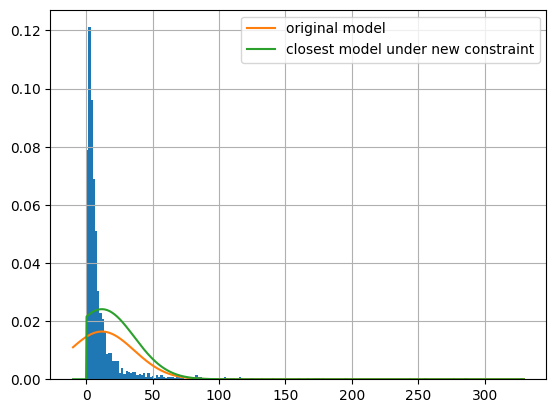

In [86]:
mv.hist(bins=200, density=True)
plt.plot(x, np.exp(tweaked_model.prior_log_pdf(x)), label='original model')
plt.plot(x, y, label='closest model under new constraint')
plt.legend();

Notice that this model now reflects the one constraint we have given it: that all the probability density is allocated to the region $x \geq 0$.

### Improving further upon a given model

Clearly a failure of the model above is that it doesn't give enough weight to values close to zero.

What would be the density with closest KL divergence to this Gaussian model subject to one additional constraint: the probability that the mv are between -2 and 2 (billion USD) is the same as that in the sample?

In [ ]:
def f1(x):
    return (x > -2) & (x < 2)

In [ ]:
features = [f0, f1]

In [ ]:
target_expectations = [f0(mv).mean(), f1(mv).mean()]        # P(X > 0) = 1

In [ ]:
target_expectations

In [ ]:
# create a model
tweaked_model = scipy_maxentropy.BigModel()
tweaked_model.setsampleFgen(sampleFgen(sampler, features))
tweaked_model.prior_log_pdf = auxmodel.logpdf

In [ ]:
# X = np.reshape(target_expectations, (1, -1))
# X.shape

In [ ]:
tweaked_model.verbose = True
tweaked_model.avegtol = 1e-5
tweaked_model.fit(target_expectations)

In [ ]:
tweaked_model.expectations()

In [ ]:
pdf = tweaked_model.pdf(np.array([f(x) for f in features]))

In [ ]:
mv.hist(bins=100, density=True)
plt.plot(x, pdf)
plt.plot(x, auxmodel.pdf(x))
plt.xlim(-50, 50)

### Experiment: Constraining the mean

If we constrain the mean to be the same as the mean in the sample:

In [ ]:
def f1(x):
    return x

In [ ]:
features = [f0, f1]

In [ ]:
target_expectations = [f0(mv).mean(), f1(mv).mean()]        # P(X > 0) = 1

In [ ]:
target_expectations

In [ ]:
# create a model
tweaked_model = scipy_maxentropy.BigModel()
tweaked_model.setsampleFgen(sampleFgen(sampler, features))
tweaked_model.prior_log_pdf = auxmodel.logpdf

In [ ]:
# X = np.reshape(target_expectations, (1, -1))
# X.shape

In [ ]:
tweaked_model.fit(target_expectations)

In [ ]:
tweaked_model.expectations()

In [ ]:
pdf = tweaked_model.pdf(np.array([f(x) for f in features]))

In [ ]:
mv.hist(bins=100, density=True)
plt.plot(x, pdf)
plt.plot(x, auxmodel.pdf(x))
plt.xlim(-50, 50)

This is the closest model to the starting model (in a KL divergence sense) that satisfies additional constraints in the form of linear expectation constraints.